# GCOS Reference Upper-Air Network (GRUAN) data to evaluate ECMWF ERA5 reanalysis products

Production date: 15-11-2025

Produced by: V. Ciardini (ENEA), ...

## 🌍 Use case: Use case listed here in full 

## ❓ Quality assessment question 
* **How do ERA5 reanalysis products perform against GCOS Reference Upper-Air Network data?**

### *The GCOS Reference Upper Air Network (GRUAN)*
Envisioned by the WMO in the 2007, GRUAN is a **reference** network that aims to establish 30-40 observing stations to, among other things, maintain measurements over several decades to accurately quantify trends, to fully characterize the properties of the atmospheric column, and to further our understanding of climate variability and change. Key points for reference quality are the traceability of the calibration and the analysis of measurement uncertainties. GRUAN responds to strict requirements such as measurement accuracy and long-term stability upon observing systems; all contribution of the measurement uncertainties are determined and documented, and radiosonde data are provided with vertically resolved uncertainties (random and systematic). 
Currently, data from 18 stations are available on the CDS for the period 2006-2020 are available (depending on the station radiosounding frequency).

## 📢 Quality assessment statement

```{admonition} These are the key outcomes of this assessment
:class: note
* Finding 1
* Finding 2
* Finding 3
* etc
```

## 📋 Methodology

The notebook will follow approximately the following methodology:

**Collect & Prepare Data**

- Download ERA5 pressure-level temperature, humidity, and wind for selected GRUAN stations and time periods.
- Download corresponding GRUAN radiosonde profiles.
- Interpolate GRUAN profiles to the same standard pressure levels used by ERA5 so the two datasets can be directly compared.
  
**Collocate ERA5 and GRUAN**
  
- Match each GRUAN profile with the nearest ERA5 time and grid point.
- Build a joint dataset for each station containing ERA5 and GRUAN values on the same time × pressure grid.
- Compare Using Hovmöller Diagrams: for each variable (temperature, humidity, wind), create ERA5, GRUAN, and difference Hovmöller diagrams (time vs. pressure) (only selected cases are shown as examples). These illustrate how profiles evolve over time and where ERA5 deviates from observations.

**Quantify Performance With Taylor Diagrams**
  
- Compute correlation, standard deviation, and root mean squared error between ERA5 and GRUAN.
- Summarize these metrics in Taylor diagrams, either: one diagram per variable, or one combined diagram for all veriables (if it is readable)

The analysis and results are organised in the following steps, which are detailed in the sections below:

**[](section-1)**
 * ...

**[](section-2)**
 * ...

**[](section-3)**
 * ...

**[](section-4)**
 * ...

**[](section-5)**
 * ...

**[](section-6)**
 * ...

## 📈 Analysis and results

(section-1)=
### 1. Import libraries

In [1]:
import os

import cdsapi
import numpy as np
import pandas as pd
import xarray as xr
import skill_metrics as sm  # pip install SkillMetrics
from matplotlib.ticker import ScalarFormatter
import matplotlib.pyplot as plt
from c3s_eqc_automatic_quality_control import download

os.environ["CDSAPI_RC"] = os.path.expanduser("~/ciardini_virginia/.cdsapirc")

(section-2)=
### 2. Define parameters

In [2]:
# Time period
start = "2006-05"
stop = "2020-03"

# Regions
stations = {
    "NYA": {"latitude": 78.92, "longitude": 11.93},
    "BAR": {"latitude": 71.32, "longitude": -156.61},
    "SOD": {"latitude": 67.37, "longitude": 26.63},
    "LIN": {"latitude": 52.21, "longitude": 14.12},
    "TEN": {"latitude": 28.32, "longitude": -16.38},
    #"BEL": {"latitude":  39.05, "longitude": -76.88},
    #"BOU": {"latitude":  39.95, "longitude": -105.20},
    #"CAB": {"latitude":  51.97, "longitude": 4.92},
    #"GRA": {"latitude": 39.09, "longitude": -28.03},
    #"LAU": {"latitude":  -45.05, "longitude": 169.68},
    #"MAN": {"latitude": -2.06, "longitude": 147.42},
    #"NAU": {"latitude":  -0.52, "longitude": 166.92},    
    #"PAY": {"latitude":46.81, "longitude": 6.95},
    #"POT": {"latitude": 40.60, "longitude": 15.72},
    #"REU": {"latitude": -21.08, "longitude": 55.383},
    #"SGP": {"latitude": 36.60, "longitude": -97.49},  
    #"TAT": {"latitude": 36.06, "longitude": 140.13}
    
}
assert isinstance(stations, dict)

# Pressure levels
levels = [
    "100",
    "125",
    "150",
    "175",
    "200",
    "225",
    "250",
    "300",
    "350",
    "400",
    "450",
    "500",
    "550",
    "600",
    "650",
    "700",
    "750",
    "775",
    "800",
    "825",
    "850",
    "875",
    "900",
    "925",
    "950",
    "975",
    "1000",
]

(section-3)=
### 3. Define requests

In [3]:
# GRUAN
collection_id_gruan = "insitu-observations-gruan-reference-network"
request_gruan = {
    "version": "1_0_0",
    "variable": [
        "air_temperature",
        "relative_humidity",
        "air_pressure",
        "altitude",
        "eastward_wind_speed",
        "northward_wind_speed",
    ],
    "data_format": "netcdf",
}

# ERA5
collection_id_era5 = "reanalysis-era5-pressure-levels-monthly-means"
request_era5 = {
    "product_type": "monthly_averaged_reanalysis",
    "variable": [
        "temperature",
        "u_component_of_wind",
        "v_component_of_wind",
        "relative_humidity",
    ],
    "pressure_level": levels,
    "time": "00:00",
    "data_format": "grib",
    "download_format": "unarchived",
}

# Build requests
client = cdsapi.Client(sleep_max=10)
requests_gruan = []
requests_era5 = []
for date in pd.date_range(start, stop, freq="1MS"):
    # GRUAN
    time_request = {"year": date.strftime("%Y"), "month": date.strftime("%m")}
    time_request["day"] = client.client.apply_constraints(
        collection_id_gruan, request_gruan | time_request
    )["day"]
    if time_request["day"]:
        requests_gruan.append(request_gruan | time_request)
    # ERA5
    requests_era5.append(request_era5 | time_request)

2025-12-29 21:28:05,554 INFO [2025-12-03T00:00:00Z] To improve our C3S service, we need to hear from you! Please complete this very short [survey](https://confluence.ecmwf.int/x/E7uBEQ/). Thank you.


(section-4)=
### 4. Functions to cache

In [4]:
def _reorganize_dataset(ds):
    # Rename
    (varname,) = set(ds["observed_variable"].values)
    ds = ds.rename(observation_value=str(varname)).drop_vars("observed_variable")
    ds = ds.rename(
        {
            var: "_".join([varname, var.replace("_value", "")])
            for var in ds.data_vars
            if var.startswith("uncertainty")
        }
    )
    # Update attrs
    for var, da in ds.data_vars.items():
        da.attrs["long_name"] = var.replace("_", " ").title()
        for string in ("units", "type"):
            if string in var:
                ds = ds.drop_vars(var)
                (value,) = set(da.values)
                attrs_var = varname if var == string else var.replace("_" + string, "")
                ds[attrs_var].attrs[string] = value
    return ds


def reorganize_dataset(ds):
    for var, da in ds.data_vars.items():
        if np.issubdtype(da.dtype, np.bytes_):
            ds[var].values = np.char.decode(da.values, "utf-8")

    if not ds.sizes["index"]:
        return ds

    datasets = []
    for var, ds in ds.groupby("observed_variable"):
        datasets.append(_reorganize_dataset(ds))
    with xr.set_options(use_new_combine_kwarg_defaults=True):
        return xr.merge(datasets)


def compute_interpolated_insitu_profiles(ds, levels, variables):
    ds = reorganize_dataset(ds)

    # Add time index
    ds["time"] = ("index", pd.to_datetime(ds["report_timestamp"]).values)

    # Variables to retain
    profiles = []
    for station, ds_station in ds.groupby("primary_station_id"):
        for time, profile in ds_station.groupby("time"):
            # Organizza il profilo per altitudine
            profile = profile.swap_dims(index="altitude")[variables]
            profile = profile.sortby("altitude")
            profile = profile.dropna("altitude", how="any", subset=variables)
            profile = profile.drop_duplicates("altitude")

            # Quality check
            if (
                not profile.sizes["altitude"]
                or (profile["altitude"].diff("altitude") > 2_000).any()
            ):
                continue

            # Interpolate
            if "pressure" not in profile:
                profile["pressure"] = 1013.25 * np.exp(-profile["altitude"] / 8434.5)
            profile = profile.swap_dims(altitude="pressure").drop_duplicates("pressure")
            try:
                profile = profile.interp(pressure=levels)
            except Exception:
                print(profile)
                raise
            profile["pressure"].attrs.update({"long_name": "Pressure", "units": "hPa"})

            # Append
            profile = profile.expand_dims(time=[time])
            profile = profile.assign_coords(station=("time", [station]))
            profiles.append(profile)
    return xr.concat(profiles, dim="time")


def select_nearest_station(ds, latitude, longitude):
    return ds.sel(latitude=latitude, longitude=longitude, method="nearest")

(section-5)=
### 5. GRUAN

In [5]:
ds_gruan = download.download_and_transform(
    collection_id_gruan,
    requests_gruan,
    chunks={"year": 1, "month": 1},
    transform_func=compute_interpolated_insitu_profiles,
    transform_func_kwargs={
        "levels": sorted(map(float, levels)),
        "variables": sorted(
            [
                "pressure" if variable == "air_pressure" else variable
                for variable in request_gruan["variable"]
            ]
        ),
    },
    cached_open_mfdataset_kwargs={"concat_dim": "time", "combine": "nested"},
)

if stations is not None:
    ds_gruan = ds_gruan.where(
        ds_gruan["station"].isin(sorted(stations)).compute(), drop=True
    )
ds_gruan = ds_gruan.compute()

ds_gruan_stations = xr.concat(
    [
        ds.drop_vars("station").expand_dims(station=[station])
        for station, ds in ds_gruan.groupby("station")
    ],
    "station",
    join="outer",
)

100%|██████████| 167/167 [00:06<00:00, 27.57it/s]


(section-6)=
### 6. ERA5

In [6]:
datasets = []
for station, transform_func_kwargs in stations.items():
    print(f"{station=}")
    ds = download.download_and_transform(
        collection_id_era5,
        requests_era5,
        transform_func=select_nearest_station,
        transform_func_kwargs=transform_func_kwargs,
    )
    datasets.append(ds.expand_dims(station=[station]))
ds_era5 = xr.concat(datasets, "station").compute()

# Convert plev to hPa (mb)
ds_era5["plev"] = ds_era5["plev"] / 100
ds_era5["plev"].attrs.update({"long_name": "Level", "units": "hPa"})

station='NYA'


100%|██████████| 167/167 [00:07<00:00, 21.29it/s]


station='BAR'


100%|██████████| 167/167 [00:07<00:00, 21.73it/s]


station='SOD'


100%|██████████| 167/167 [00:07<00:00, 22.78it/s]


station='LIN'


100%|██████████| 167/167 [00:08<00:00, 19.02it/s]


station='TEN'


100%|██████████| 167/167 [00:12<00:00, 13.60it/s]
/data/wp5/.tmp/ipykernel_3376009/884858239.py:11: FutureWarning: In a future version of xarray the default value for coords will change from coords='different' to coords='minimal'. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set coords explicitly.
  ds_era5 = xr.concat(datasets, "station").compute()


In [7]:
toplot = {
    "Temperature" : {
       "vname"   : "t",
       "levels"  : np.arange(-5, 5.5, 0.5),
       "yscale"  : "log",
       "ylim"    : [1000, 100],
       "yticks"  : [1000,600,500,400,300,200,100],
       "cmap"    : "RdBu_r"
    },
    "U component of wind" : {
       "vname"   : "u",
       "levels"  : np.arange(-20, 22, 2),
       "yscale"  : "log",
       "ylim"    : [1000, 100],
       "yticks"  : [1000,600,500,400,300,200,100],
       "cmap"    : "PuOr"
    },
    "Relative Humidity" : {
       "vname"   : "r",
       "levels"  : np.arange(-5, 5.5, 0.5),
       "yscale"  : "linear",
       "ylim"    : [1000, 100],
       "yticks"  : [1000,500,200,100],
       "cmap"    : "BrBG"
    },
}

In [8]:
# ===== ERA5 anomalies =====
with xr.set_options(keep_attrs=True):
    ds_anoma = ds_era5.groupby("forecast_reference_time.month") - \
               ds_era5.groupby("forecast_reference_time.month").mean("forecast_reference_time")
    for varname in list(ds_anoma.data_vars):
        ds_anoma[varname].attrs["long_name"] = ds_era5[varname].attrs.get("long_name", varname) + " anomaly"
        ds_anoma[varname].attrs["units"]     = ds_era5[varname].attrs.get("units", "")

# ===== GRUAN anomalies =====
time_gruan = "time"

# Calcolo delle anomalie per il dataset ristrutturato (ds_gruan_stations)
with xr.set_options(keep_attrs=True):
    # Raggruppiamo per mese, calcoliamo la media mensile e sottraiamo la media mensile da ciascun valore
    ds_gruan_anoma = ds_gruan_stations.groupby(f"{time_gruan}.month") - \
                     ds_gruan_stations.groupby(f"{time_gruan}.month").mean(time_gruan, skipna=True)

    # Aggiungere l'attributo "long_name" per indicare che i dati sono anomalie
    for varname in list(ds_gruan_anoma.data_vars):
        base_long = ds_gruan_stations[varname].attrs.get("long_name", varname)
        ds_gruan_anoma[varname].attrs["long_name"] = f"{base_long} anomaly"
        ds_gruan_anoma[varname].attrs["units"] = ds_gruan_stations[varname].attrs.get("units", "")

In [11]:
gruan_var_map = {
    "t": "air_temperature",
    "u": "eastward_wind_speed",
    "r": "relative_humidity",
}

In [12]:
toplot = {
    "Temperature" : {
       "vname"   : "t",
       "levels"  : np.arange(-5, 5.5, 0.5),
       "yscale"  : "log",
       "ylim"    : [1000, 100],
       "yticks"  : [1000,600,500, 400,300, 200,100],
       "cmap"    : "RdBu_r"
    },
    "U component of wind" : {
       "vname"   : "u",
       "levels"  : np.arange(-20, 20+2, 2),
       "yscale"  : "log",
       "ylim"    : [1000, 100],
       "yticks"  : [1000,600,500,400,300,200,100],
       "cmap"    : "PuOr"
    },
    "Relative Humidity" : {
       "vname"   : "r",
       "levels"  : np.arange(-5, 5+0.5, 0.5),
       "yscale"  : "linear",
       "ylim"    : [1000, 100],
       "yticks"  : [1000,500,200,100],
       "cmap"    : "BrBG"
    },
}


def plot_anomalies_for_station(ds_anoma, toplot, station=None, station_idx=None):
    """
    Plot delle anomalie per una stazione selezionata.
    - station: nome della stazione (se coordinate 'station' sono stringhe/codici)
    - station_idx: indice numerico della stazione
    Se entrambi None, usa la prima stazione disponibile.
    """

    stations = ds_anoma["station"].values
    if station is not None:
        da_sel = ds_anoma.sel(station=station)
        station_label = str(station)
    elif station_idx is not None:
  
        station_val = stations[station_idx]
        da_sel = ds_anoma.sel(station=station_val)
        station_label = str(station_val)
    else:
        station_val = stations[0]
        da_sel = ds_anoma.sel(station=station_val)
        station_label = str(station_val)

    if float(da_sel["plev"].max()) > 2000:
        da_sel = da_sel.assign_coords(plev = da_sel["plev"] / 100.0)

    # --- Plot ---
    fig, axs = plt.subplots(len(toplot), figsize=(9, 11), constrained_layout=True)

    for i, (varlabel, attr) in enumerate(toplot.items()):

        da = da_sel[attr["vname"]]
        Z = da.transpose("plev", "forecast_reference_time")
        X = da_sel["forecast_reference_time"]
        Y = da_sel["plev"]

        cf = axs[i].contourf(X, Y, Z, cmap=attr["cmap"], extend='both', levels=attr["levels"])
        axs[i].set_yscale(attr["yscale"])
        axs[i].set_yticks(attr["yticks"])
        axs[i].set_title(f"{varlabel} – {station_label}")
        axs[i].yaxis.set_major_formatter(ScalarFormatter())
        axs[i].invert_yaxis()
        axs[i].set_ylabel('[hPa]')
        axs[i].set_xlabel("")

        units = da.attrs.get("units", "")
        fig.colorbar(cf, ax=axs[i], label=units)

    axs[-1].set_xlabel("Forecast reference time")
    plt.show()

    return fig      

In [16]:
#stations = ds_anoma["station"].values
#for st in stations:
#    print(f"Plotting stazione: {st}")
#    plot_anomalies_for_station(ds_anoma, toplot, station=st)

In [17]:
def plot_side_by_side_era5_gruan_no_restruct(
    ds_era5_anoma,      # ERA5 anomalies: dims ('station','forecast_reference_time','plev')
    ds_gruan_anoma,     # GRUAN anomalies: coord 'station' (attached to 'time'), dims ('time','pressure', ...)
    toplot,
    station,            # e.g., 'LIN'
    start="2006-01-01",
    stop="2020-12-31",
    resample_gruan_to_monthly=True,  # True: GRUAN -> monthly mean for comparison with ERA5 monthly
):
    # Select ERA5 data for the station
    da_e = ds_era5_anoma.sel(station=station)  # ('forecast_reference_time', 'plev', vars)
    # Select GRUAN data for the station in the restructured dataset
    ds_g_st = ds_gruan_anoma.sel(station=station)  # ('time', 'pressure', vars)

    # Filter data for the period of interest
    da_e = da_e.sel(forecast_reference_time=slice(start, stop))
    ds_g_st = ds_g_st.sel(time=slice(start, stop))

    # If necessary, perform monthly resampling on GRUAN
    if resample_gruan_to_monthly:
        ds_g_st = ds_g_st.resample(time="1MS").mean()

    # Normalize the 'plev' coordinate if necessary
    if float(da_e["plev"].max()) > 2000:
        da_e = da_e.assign_coords(plev=da_e["plev"] / 100.0)

    # Check if the 'pressure' coordinate is present in GRUAN
    if "pressure" not in ds_g_st.coords:
        raise ValueError("Cannot find 'pressure' coordinate in GRUAN.")
    if float(ds_g_st["pressure"].max()) > 2000:
        ds_g_st = ds_g_st.assign_coords(pressure=ds_g_st["pressure"] / 100.0)

    # Prepare plotting
    nrows = len(toplot)
    fig, axs = plt.subplots(nrows, 2, figsize=(12, 3.6 * nrows), constrained_layout=True, sharey="row")
    if nrows == 1:
        axs = np.array([axs])

    gruan_var_map = {
        "t": "air_temperature",
        "u": "eastward_wind_speed",
        "r": "relative_humidity",
    }

    # Start and end dates
    start_dt = pd.to_datetime(start)
    stop_dt  = pd.to_datetime(stop)

    # Loop through variables to plot
    for i, (varlabel, attr) in enumerate(toplot.items()):

        # Select ERA5 variable
        da_e_var = da_e[attr["vname"]]  
        Z_e = da_e_var.transpose("plev", "forecast_reference_time")
        X_e = da_e["forecast_reference_time"]
        Y_e = da_e["plev"]

        # Create ERA5 plot
        cfe = axs[i, 0].contourf(
            X_e, Y_e, Z_e,
            cmap=attr["cmap"], extend="both", levels=attr["levels"]
        )
        axs[i, 0].set_title(f"{varlabel} – ERA5 – {station}")
        axs[i, 0].set_yscale(attr["yscale"])
        axs[i, 0].set_ylim(attr["ylim"])            # [1000, 100]
        axs[i, 0].set_yticks(attr["yticks"])
        axs[i, 0].yaxis.set_major_formatter(ScalarFormatter())
        axs[i, 0].set_xlim(start_dt, stop_dt)       # force X axis 2006–2020
        axs[i, 0].set_ylabel("[hPa]")
        axs[i, 0].set_xlabel("")
        fig.colorbar(cfe, ax=axs[i, 0], label=da_e_var.attrs.get("units", ""))

        # Select corresponding GRUAN variable
        v_g = gruan_var_map[attr["vname"]]
        if v_g not in ds_g_st.data_vars:
            raise KeyError(f"GRUAN variable '{v_g}' not found in ds_gruan_anoma for {station}. Variables: {list(ds_g_st.data_vars)}")

        da_g_var = ds_g_st[v_g]  

        # Check that dimensions are correct for GRUAN
        if ("pressure" in da_g_var.dims) and ("time" in da_g_var.dims):
            Z_g = da_g_var.transpose("pressure", "time")
        else:
            raise ValueError(
                f"GRUAN variable '{v_g}' does not have expected dimensions 'time' and 'pressure'. "
                f"Found dims: {da_g_var.dims}"
            )

        X_g = ds_g_st["time"]
        Y_g = ds_g_st["pressure"]

        # Create GRUAN plot
        cfg = axs[i, 1].contourf(
            X_g, Y_g, Z_g,
            cmap=attr["cmap"], extend="both", levels=attr["levels"]
        )
        axs[i, 1].set_title(f"{varlabel} – GRUAN – {station}")
        axs[i, 1].set_yscale(attr["yscale"])
        axs[i, 1].set_ylim(attr["ylim"])            # [1000, 100]
        axs[i, 1].set_yticks(attr["yticks"])
        axs[i, 1].yaxis.set_major_formatter(ScalarFormatter())
        axs[i, 1].set_xlim(start_dt, stop_dt)       # force X axis 2006–2020
        axs[i, 1].set_ylabel("")                    # y shared with left column
        axs[i, 1].set_xlabel("")
        fig.colorbar(cfg, ax=axs[i, 1], label=da_g_var.attrs.get("units", ""))

    # X-axis label
    axs[-1, 0].set_xlabel("Forecast reference time (ERA5)")
    axs[-1, 1].set_xlabel("Time (GRUAN" + (", monthly mean" if resample_gruan_to_monthly else "") + ")")
    
    # Title
    fig.suptitle(f"Anomaly profiles – ERA5 vs GRUAN – Station {station}", y=1.02)
    
    # Show plot
    plt.show()
    
    return fig

Stazioni in comune: ['BAR', 'LIN', 'NYA', 'SOD', 'TEN']
Plotting BAR …


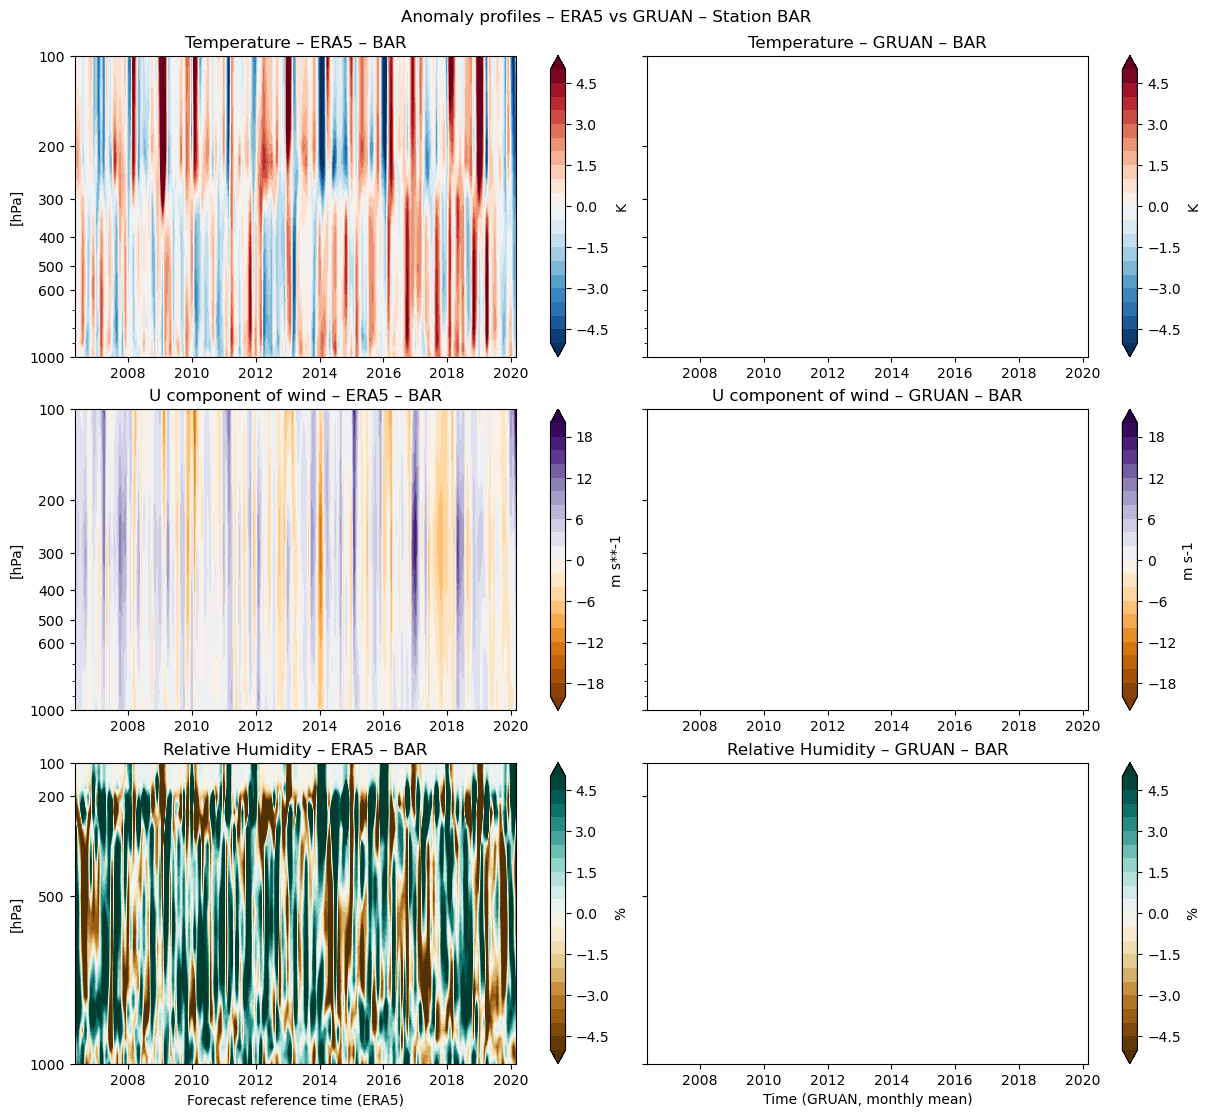

Plotting LIN …


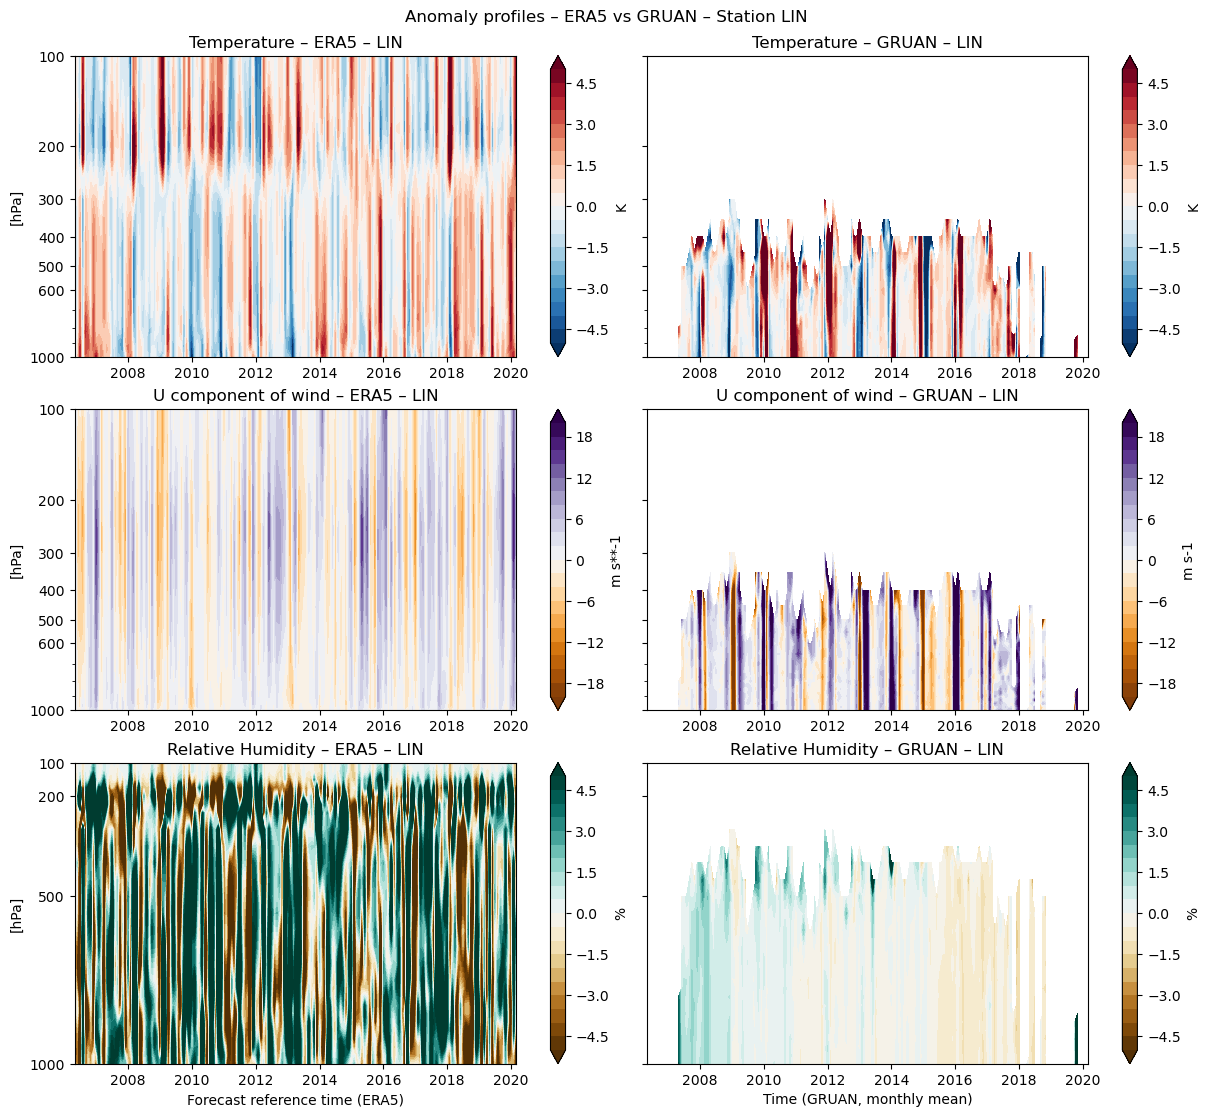

Plotting NYA …


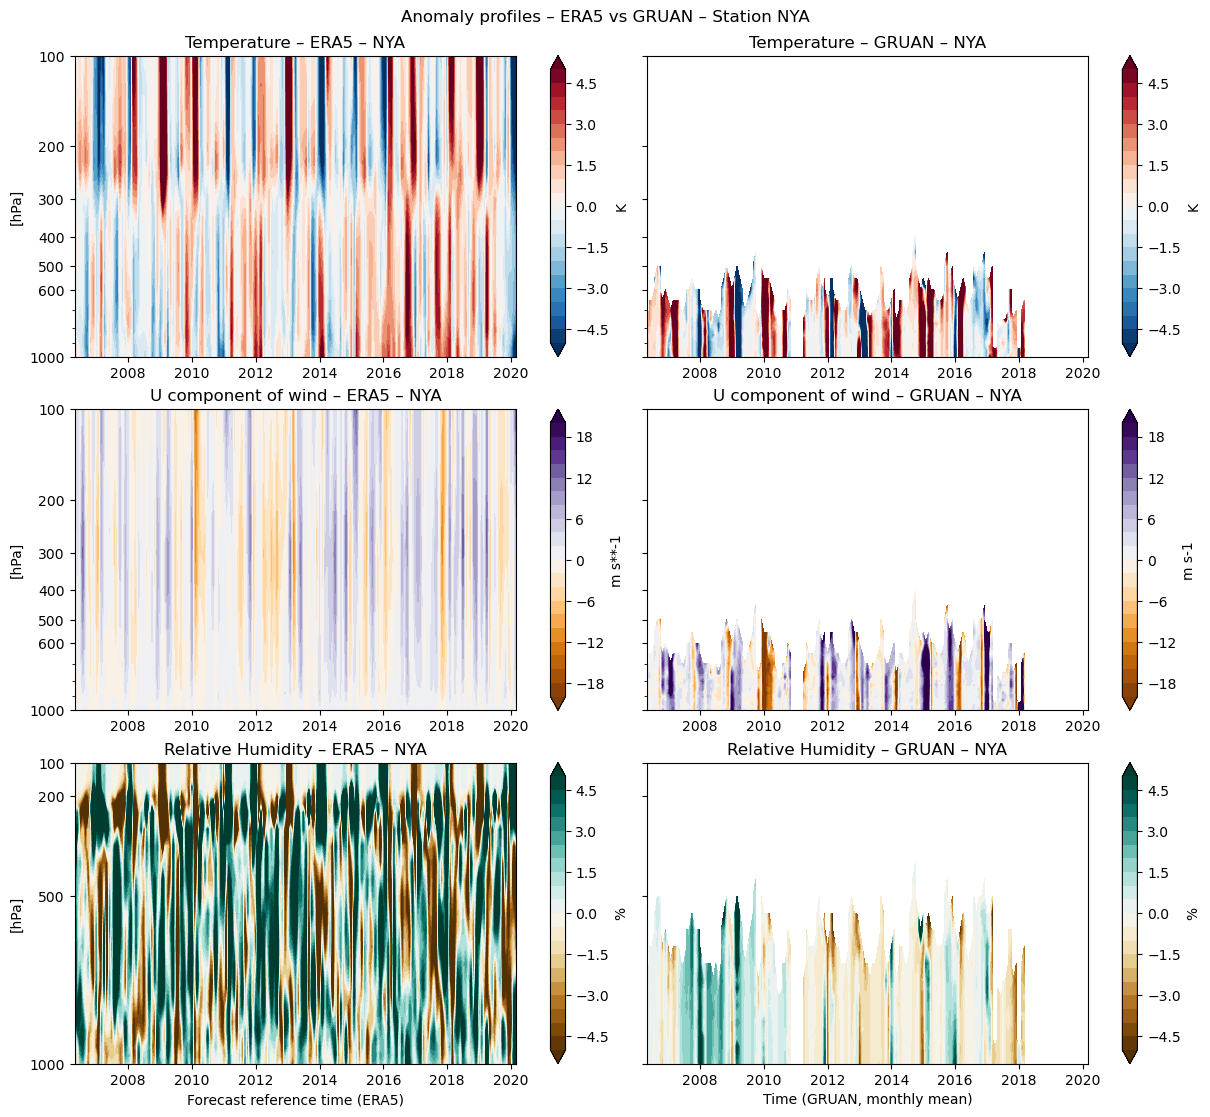

Plotting SOD …


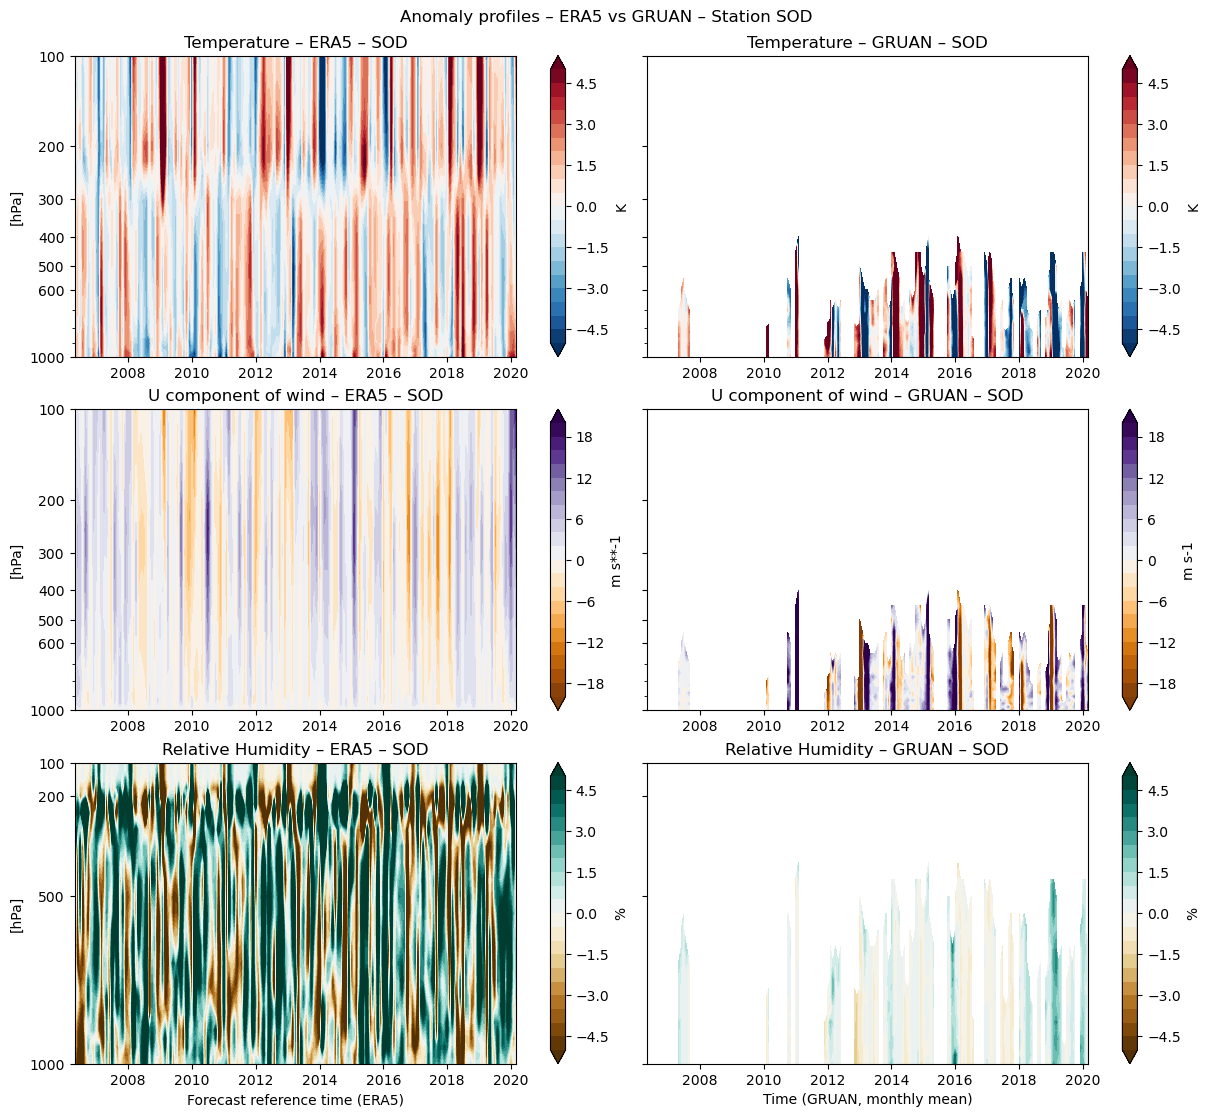

Plotting TEN …


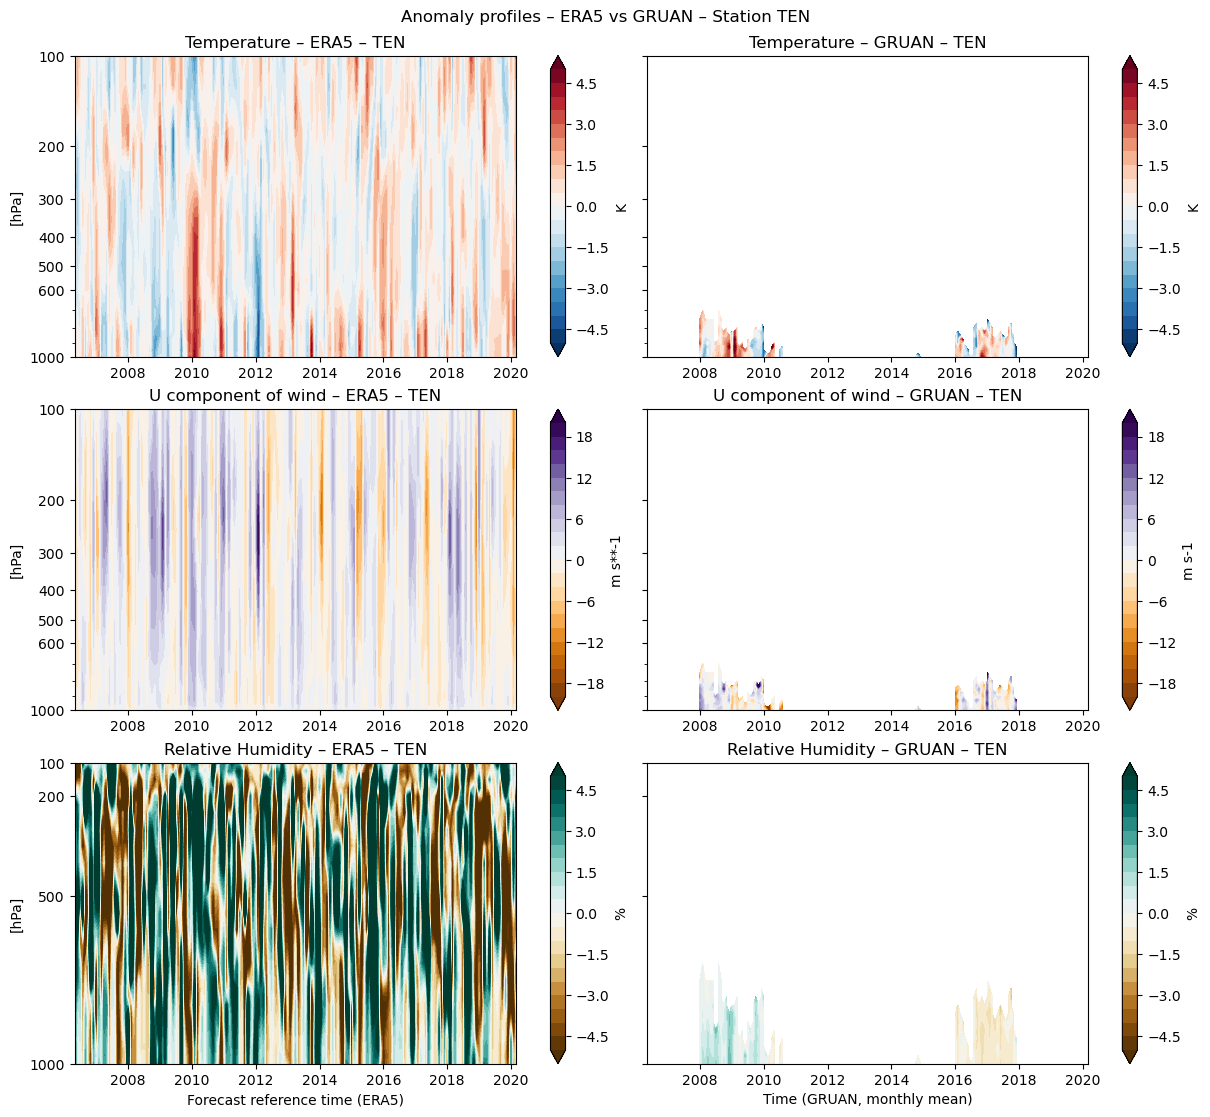

In [18]:
def _ensure_str_list(arr):
    out = []
    for v in arr:
        if isinstance(v, (bytes, np.bytes_)):
            out.append(v.decode("utf-8"))
        else:
            out.append(str(v))
    return out

era5_stations = _ensure_str_list(ds_anoma["station"].values)
gruan_stations = _ensure_str_list(ds_gruan_anoma["station"].values)
common_stations = sorted(set(era5_stations) & set(gruan_stations))
print("Stazioni in comune:", common_stations)

for st in common_stations:
    print(f"Plotting {st} …")
    plot_side_by_side_era5_gruan_no_restruct(
        ds_era5_anoma=ds_anoma,
        ds_gruan_anoma=ds_gruan_anoma,
        toplot=toplot,
        station=st,
        start=start,    # '2006-05'
        stop=stop,      # '2020-03'
        resample_gruan_to_monthly=True,
    )

Common stations: ['BAR', 'LIN', 'NYA', 'SOD', 'TEN']
⚠ BAR – air_temperature: no valid data after NaN mask, skipping.
⚠ BAR – eastward_wind_speed: no valid data after NaN mask, skipping.
⚠ BAR – relative_humidity: no valid data after NaN mask, skipping.


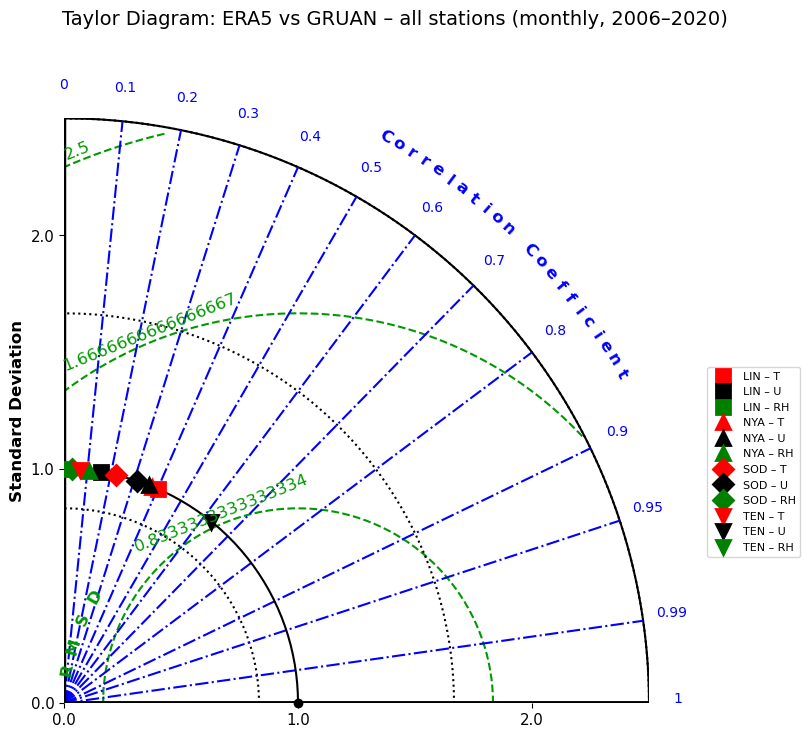

In [19]:
# 0) Fix 'time' in GRUAN (datetime64, monotonic, no duplicates)
# -----------------------------
if not np.issubdtype(ds_gruan["time"].dtype, np.datetime64):
    ds_gruan = ds_gruan.assign_coords(time=pd.to_datetime(ds_gruan["time"].values))

ds_gruan = ds_gruan.sortby("time").drop_duplicates(dim="time")
time_index = pd.DatetimeIndex(ds_gruan["time"].values)
if not time_index.is_monotonic_increasing:
    order = np.argsort(time_index.values)
    ds_gruan = ds_gruan.isel(time=order)

# -----------------------------
# 1) Taylor diagram configuration (colors/markers)
# -----------------------------
color_cycle    = ["r", "k", "g", "m", "c", "y", "b"]
marker_symbols = ["o", "s", "^", "D", "v", ">", "<", "p", "h"]  # valid Python characters

var_list     = ["t", "u", "r"]  # ERA5 abbreviations
var_labelmap = {"t": "T", "u": "U", "r": "RH"}
var_mapping  = {"t": "air_temperature", "u": "eastward_wind_speed", "r": "relative_humidity"}

sdev   = [1.0]
crmsd  = [0.0]
ccoef  = [1.0]
marker_labels = ["OBS"]

# Style lists for each point (excluding OBS)
marker_colors = []
marker_shapes = []

# -----------------------------
# 2) ERA5 time slice (already monthly)
# -----------------------------
ds_era5_m = ds_era5.sel(forecast_reference_time=slice(start, stop))

def _ensure_str_list(arr):
    out = []
    for v in arr:
        if isinstance(v, (bytes, np.bytes_)):
            out.append(v.decode("utf-8"))
        else:
            out.append(str(v))
    return out

era5_st = _ensure_str_list(ds_era5_m["station"].values)
grua_st = _ensure_str_list(ds_gruan["station"].values)
common_stations = sorted(set(era5_st) & set(grua_st))
print("Common stations:", common_stations)

# -----------------------------
# 3) Loop over stations and variables
# -----------------------------
for si, st in enumerate(common_stations):
    # ERA5 for station
    era5_st_ds = ds_era5_m.sel(station=st)

    # GRUAN for station: filter + slice + monthly resample (unique time)
    grua_st_raw = ds_gruan.where(ds_gruan["station"] == st, drop=True).sel(time=slice(start, stop))
    grua_st_ds  = grua_st_raw.resample(time="1MS").mean()

    # Unique monthly times: intersection of ERA5 vs GRUAN months
    time_e = pd.DatetimeIndex(era5_st_ds["forecast_reference_time"].values).unique()
    time_g = pd.DatetimeIndex(grua_st_ds["time"].values).unique()
    common_time = np.intersect1d(time_e.values, time_g.values)
    if common_time.size == 0:
        print(f"⚠ No common month for {st}, skipping.")
        continue

    for vi, var in enumerate(var_list):
        v_g = var_mapping[var]
        if v_g not in grua_st_ds.data_vars:
            print(f"⚠ {st}: missing GRUAN variable: {v_g}, skipping.")
            continue

        # DataArray (time × level)
        da_e = era5_st_ds[var]   # dims: (forecast_reference_time, plev)
        da_g = grua_st_ds[v_g]   # dims: (time, pressure) or (pressure, time)

        # Subset common times
        da_e_c = da_e.sel(forecast_reference_time=common_time)
        da_g_c = da_g.sel(time=common_time)

        # Order as (level, time): ERA5 (plev, time) — GRUAN (pressure, time)
        da_e_ct = da_e_c.transpose("plev", "forecast_reference_time")
        da_g_ct = da_g_c.transpose("pressure", "time") if da_g_c.dims[0] == "time" else da_g_c

        # (Optional, recommended if 27 levels do not match perfectly)
        # GRUAN on ERA5 plev:
        # da_g_ct = da_g_ct.interp(pressure=da_e_ct["plev"])

        # 1D series (level×time) and NaN mask
        ref_series = da_g_ct.values.flatten()
        mod_series = da_e_ct.values.flatten()
        mask = np.isfinite(ref_series) & np.isfinite(mod_series)
        ref_series = ref_series[mask]
        mod_series = mod_series[mask]

        if ref_series.size == 0 or mod_series.size == 0:
            print(f"⚠ {st} – {v_g}: no valid data after NaN mask, skipping.")
            continue

        # Z-score normalization (as in your code)
        ref_series = (ref_series - np.nanmean(ref_series)) / np.nanstd(ref_series)
        mod_series = (mod_series - np.nanmean(mod_series)) / np.nanstd(mod_series)

        # Taylor statistics
        stats = sm.taylor_statistics(mod_series, ref_series, "data")

        # Add point
        sdev.append(stats["sdev"][1])
        crmsd.append(stats["crmsd"][1])
        ccoef.append(stats["ccoef"][1])
        marker_labels.append(f"{st} – {var_labelmap[var]}")

        # Style: color for variable, marker for station
        marker_colors.append(color_cycle[vi % len(color_cycle)])
        marker_shapes.append(marker_symbols[si % len(marker_symbols)])

# -----------------------------
# 4) Consistency check for lists
# -----------------------------
assert len(sdev) == len(crmsd) == len(ccoef) == len(marker_labels), \
    f"Lengths not aligned: sdev={len(sdev)}, crmsd={len(crmsd)}, ccoef={len(ccoef)}, labels={len(marker_labels)}"
assert len(marker_colors) == len(marker_shapes) == (len(marker_labels) - 1), \
    f"Style not aligned (excluding OBS): colors={len(marker_colors)}, shapes={len(marker_shapes)}, labels-1={len(marker_labels)-1}"

MARKERS = {}
for lbl, col, shp in zip(marker_labels[1:], marker_colors, marker_shapes):
    MARKERS[lbl] = {
        "labelColor": "k",  # text color in legend
        "symbol": shp,      # marker symbol
        "size": 10,         # size
        "faceColor": col,   # fill color
        "edgeColor": col,   # border color
    }

# -----------------------------
# 6) Draw Taylor diagram (using markers={...})
# -----------------------------
plt.figure(figsize=(8, 8))
sm.taylor_diagram(
    np.array(sdev),
    np.array(crmsd),
    np.array(ccoef),
    markerLabel=marker_labels,   # includes 'OBS' + points
    markers=MARKERS,             # dictionary per-point (full style)
    markerLegend="on",           # show marker legend
    markerSize=10,               # default (can ignore if using MARKERS)
    styleOBS="-",
    colOBS="k",
    markerobs="o",
    axisMax=2.5,                 # correct option name (Axis Max)
    numberPanels=1,              # only positive correlations
)
plt.gcf().suptitle("Taylor Diagram: ERA5 vs GRUAN – all stations (monthly, 2006–2020)", fontsize=14)
plt.tight_layout()
plt.savefig("taylor_diagram_all_stations.png", dpi=300)
plt.show()

## ℹ️ If you want to know more

### Key resources

CDS catalogue entries used in this notebook are:

[In situ temperature, relative humidity and wind profiles from 2006 to March 2020 from the GRUAN reference network](https://cds.climate.copernicus.eu/datasets/insitu-observations-gruan-reference-network?tab=overview)

[ERA5 monthly averaged data on pressure levels from 1940 to present](https://cds.climate.copernicus.eu/datasets/reanalysis-era5-pressure-levels-monthly-means?tab=overview)

* Product [Documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) for GRUAN and
* Product [Documentation](https://confluence.ecmwf.int/display/CKB/ERA5%3A+data+documentation) for ERA5 are available 

external pages:

[GRUAN website](https://www.gruan.org/), `GCOS Reference Upper-Air Network`

Code libraries used:
* [C3S EQC custom functions](https://github.com/bopen/c3s-eqc-automatic-quality-control/tree/main/c3s_eqc_automatic_quality_control), `c3s_eqc_automatic_quality_control`,  prepared by [B-Open](https://www.bopen.eu/)
* [Xarray](https://pypi.org/project/xarray/) for working with multidimensional arrays in Python
* [Matplotlib](https://pypi.org/project/matplotlib/) for visualization in Python 
* [Scipy](https://pypi.org/project/scipy/) for statistics in Python
* [skill_metrics](https://pypi.org/project/SkillMetrics/) for calculating the skill of model predictions against observations

### References

List the references used in the Notebook here.

E.g.

[[1]](https://doi.org/10.1038/s41598-018-20628-2) Rodriguez, D., De Voil, P., Hudson, D., Brown, J. N., Hayman, P., Marrou, H., & Meinke, H. (2018). Predicting optimum crop designs using crop models and seasonal climate forecasts. Scientific reports, 8(1), 2231.